In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import src.utils as utils
import scipy
import seaborn as sns
from scipy.signal import detrend
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from scipy import stats


In [2]:
# Import DataFrames
observatoire = utils.get_observatoire(remove_dubious=True)


We would like to look at the evolution of many variables over the course of time. We first take a look at temperature.


In [28]:
def months(data_frame):
    return data_frame.DATE.apply(lambda n: int(str(n)[4:6]))


def years(data_frame):
    return data_frame.DATE.apply(lambda n: int(str(n)[0:4]))


def is_29_feb(df):
    return pd.to_datetime(df.DATE, format="%Y%m%d").apply(
        lambda r: r.timetuple().tm_mon == 2 and r.timetuple().tm_mday == 29
    )


observatoire["years"] = years(observatoire)
observatoire["months"] = months(observatoire)

observatoire["datetime"] = pd.to_datetime(observatoire.DATE, format="%Y%m%d")

# remove 29th of february
mask = is_29_feb(observatoire)
observatoire = observatoire.drop(observatoire.loc[mask].index)
assert not is_29_feb(observatoire).values.any()

nth_day = pd.to_datetime(observatoire.DATE, format="%Y%m%d").apply(
    lambda r: r.timetuple().tm_yday
)
observatoire["nth_day"] = nth_day
mean_per_day = observatoire.groupby("nth_day")["TG"].mean()


regrouped = observatoire.groupby(["years", "months"], as_index=False)["TG"].mean()

pd.options.display.max_rows = 4000
print(observatoire.DATE)
# print(regrouped.head())
# plt.figure(figsize=(20, 6), dpi=80)
# plt.plot(regrouped.index, regrouped.TG)

# for year in regrouped.years.unique():
# by_month = regrouped[regrouped.years == year].groupby('months')['TG'].mean()
# sns.relplot(x=by_month.index, y=by_month, kind="line")


0        19010101
1        19010102
2        19010103
3        19010104
4        19010105
           ...   
44068    20210827
44069    20210828
44070    20210829
44071    20210830
44072    20210831
Name: DATE, Length: 44043, dtype: int64


In [21]:
# Markov autoregression
group_years = observatoire.groupby(["years"], as_index=False)["TG"].mean()
print(group_years)
markov_tg = sm.tsa.MarkovAutoregression(
     group_years.TG, k_regimes=2, order=4,
)
res_markov_tg = markov_tg.fit()


     years          TG
0     1901   91.819178
1     1902   93.789041
2     1903   95.063014
3     1904  102.671233
4     1905   95.504110
..     ...         ...
116   2017  113.287671
117   2018  123.076712
118   2019  118.210959
119   2020  121.706849
120   2021  108.962617

[121 rows x 2 columns]


In [22]:
res_markov_tg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                       TG   No. Observations:                  117
Model:             MarkovAutoregression   Log Likelihood                -372.145
Date:                  Tue, 26 Oct 2021   AIC                            770.290
Time:                          14:38:30   BIC                            806.198
Sample:                               0   HQIC                           784.868
                                  - 117                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.8299   9.14e-11   9.83e+11      0.000      89.830      89.830
ar.L1          0.6211    1.5e-14   4.13e+13      0.000       0.621       0.621
ar.L2          0.0984   3.17e-14    3.1e+12      0.000       0.098       0.098
ar.L3         -0.4539   1.54e-14  -2.95e+13      0.000      -0.454      -0.454
ar.L4         -0.0066   2.19e-14  -3.03e+11      0.000      -0.007      -0.007
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.0036      2.908     35.765      0.000      98.304     109.703
ar.L1          0.3703      0.093      3.991      0.000       0.188       0.552
ar.L2          0.3022      0.099      3.057      0.002       0.108       0.496
ar.L3          0.1186      0.099      1.193      0.233      -0.076       0.313
ar.L4          0.0191      0.095      0.200      0.841      -0.167       0.206
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        33.9054      4.433      7.649      0.000      25.217      42.594
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     4.641e-06      9.014   5.15e-07      1.000     -17.668      17.668
p[1->0]     8.057e-21   6.49e-10   1.24e-11      1.000   -1.27e-09    1.27e-09
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 8.65e+42. Standard errors may be unstable.
"""

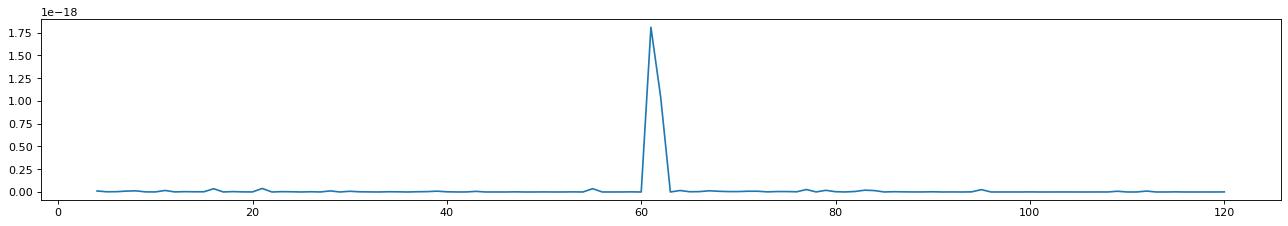

In [23]:
plt.figure(figsize=(20, 3), dpi=80)
plt.plot(res_markov_tg.filtered_marginal_probabilities[0])
# ???


<AxesSubplot:>

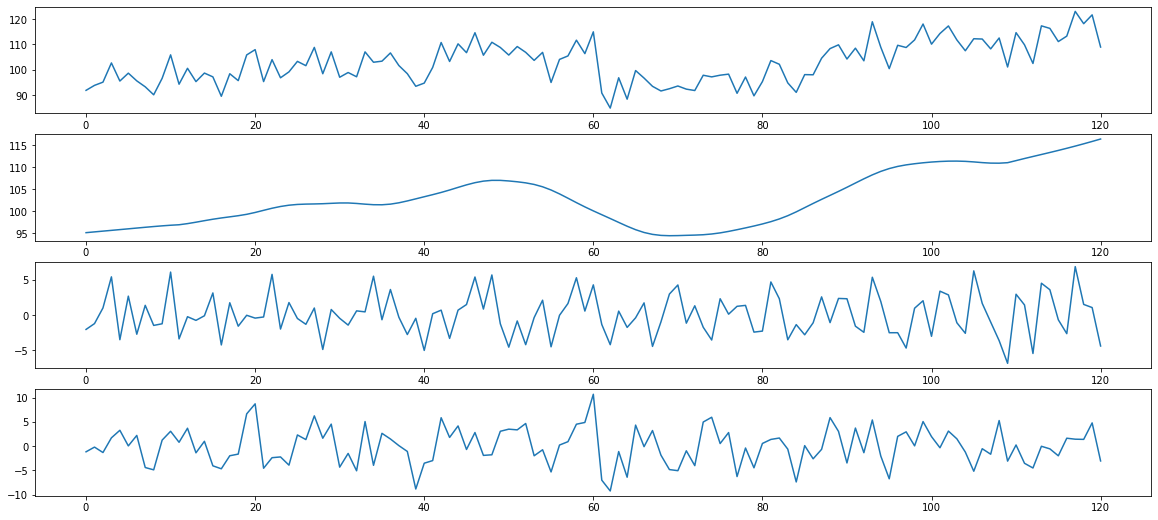

In [24]:
from statsmodels.tsa.seasonal import STL

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 9))
stl = STL(group_years.TG, period=12)
res = stl.fit()
res.observed.plot(ax=ax1)
res.trend.plot(ax=ax2)
res.seasonal.plot(ax=ax3)
res.resid.plot(ax=ax4)


In [8]:
lm1 = smf.ols("RR ~ TG + np.power(TG, 2) ", data=observatoire).fit()
# plt.scatter(cointrin.TG[lm1.fittedvalues.index], cointrin.RR[lm1.fittedvalues.index])
# plt.plot(cointrin.TG[lm1.fittedvalues.index], lm1.fittedvalues, color = "orange")

models = []

for day in observatoire.nth_day.unique():
    subday = observatoire[observatoire.nth_day == day][["TG", "years"]]
    lm = smf.ols("TG ~ years", data=subday).fit()
    models.append(lm)

# for day in observatoire.nth_day.unique():
# lm = smf.ols("TG ~ nth_day + years", data=observatoire).fit()
# models.append(lm)
# print(lm1.summary())
# fig, axes = plt.subplots(figsize=(70,12))


0   -0.041752
1    0.329233
Name: years, dtype: float64

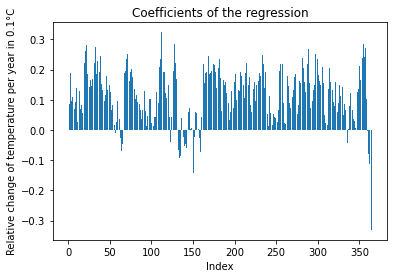

In [39]:
pvals = pd.Series([model.pvalues[1] for model in models])
coefs = pd.Series([model.params[1] for model in models])
plt.title("Coefficients of the regression")
plt.ylabel("Relative change of temperature per year in 0.1°C")
plt.xlabel("Index")
plt.bar(coefs.index, coefs)
# plt.bar(pvals.index, pvals)

# fig, ax = plt.subplots()

# ax.plot(mean_per_day.index, mean_per_day)
models[0].conf_int().loc["years"]
# ax.plot(mean_per_day.index, conf_ints[1])


0.3114754098360656
combined_stat: 1681.0500178406005, combined_pvalue: 1.8730402085382983e-76


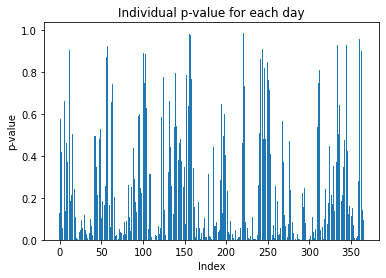

In [38]:
pvals = pd.Series([model.pvalues[1] for model in models])

fig.dpi = 300
plt.title("Individual p-value for each day")
plt.ylabel("p-value")
plt.xlabel("Index")
plt.bar(pvals.index, pvals)
print(pvals[pvals < 0.05].count() / pvals.size)
pval_combined = stats.combine_pvalues(pvals)
print("combined_stat: {}, combined_pvalue: {}".format(pval_combined[0], pval_combined[1]))

NameError: name 'cointrin' is not defined

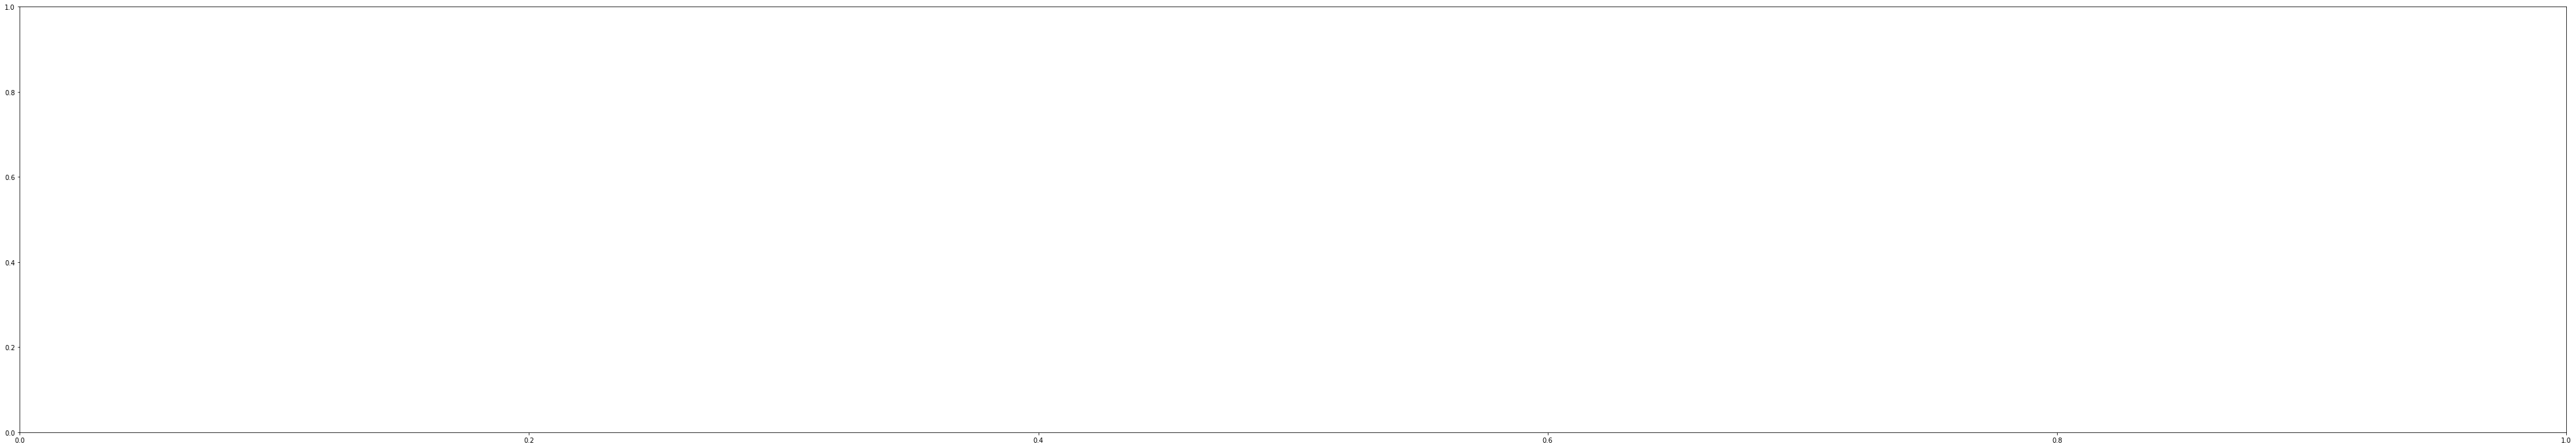

In [10]:
fig, axes = plt.subplots(figsize=(70, 12))
plt.plot(lm1.fittedvalues.index, cointrin.RR[lm1.fittedvalues.index])
plt.plot(lm1.fittedvalues.index, lm1.fittedvalues)


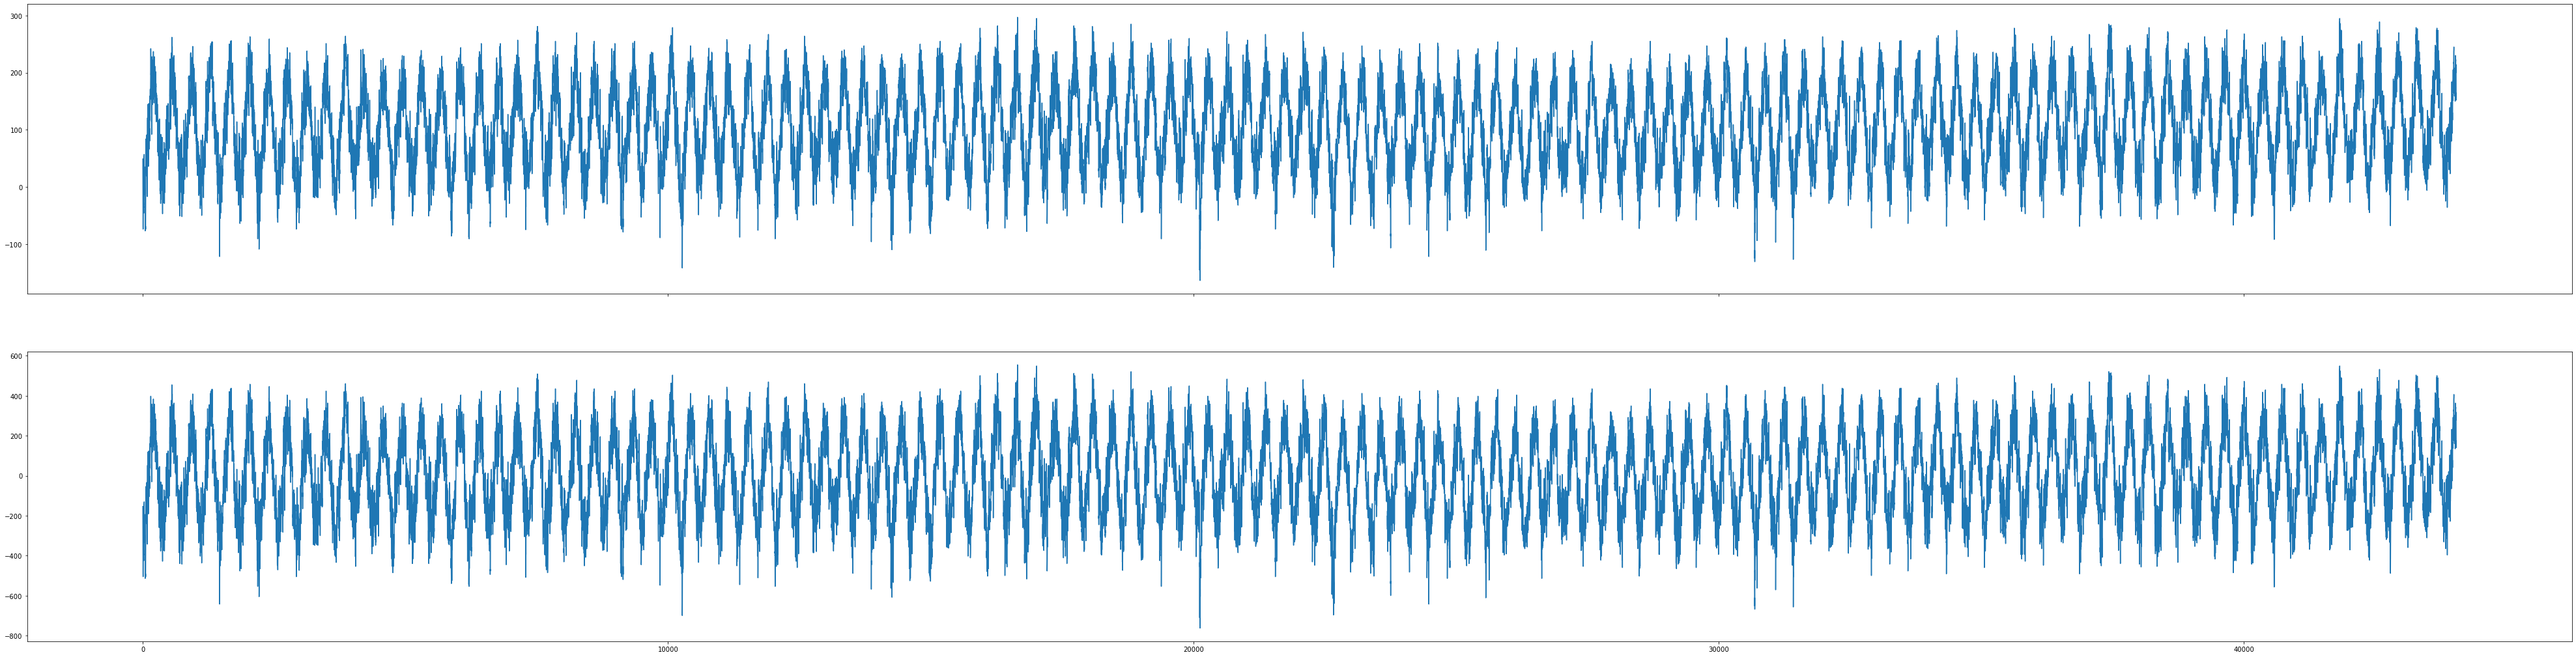

In [ ]:
# Before working with the data let's normalize it
n = observatoire.index.size
normzed = (np.sqrt(n) / observatoire.TG.std()) * (
    observatoire.TG - observatoire.TG.mean()
)
fig, axes = plt.subplots(figsize=(70, 18), nrows=2)
observatoire.TG.plot(kind="line", ax=axes[0])
normzed.plot(kind="line", ax=axes[1], sharex=True, sharey=True)

observatoire["TG_N"] = normzed


# Linear models
# Y = TG, x = day
# Y ~ b_0 + b_1 * sin(x) + b_2 * x

# lm1 = smf.ols('TG_N ~ PP', data=observatoire).fit()
# print(lm1.params)
# plt.plot(observatoire.TG.dropna().index, lm1.fittedvalues)

# print(lm1.summary())


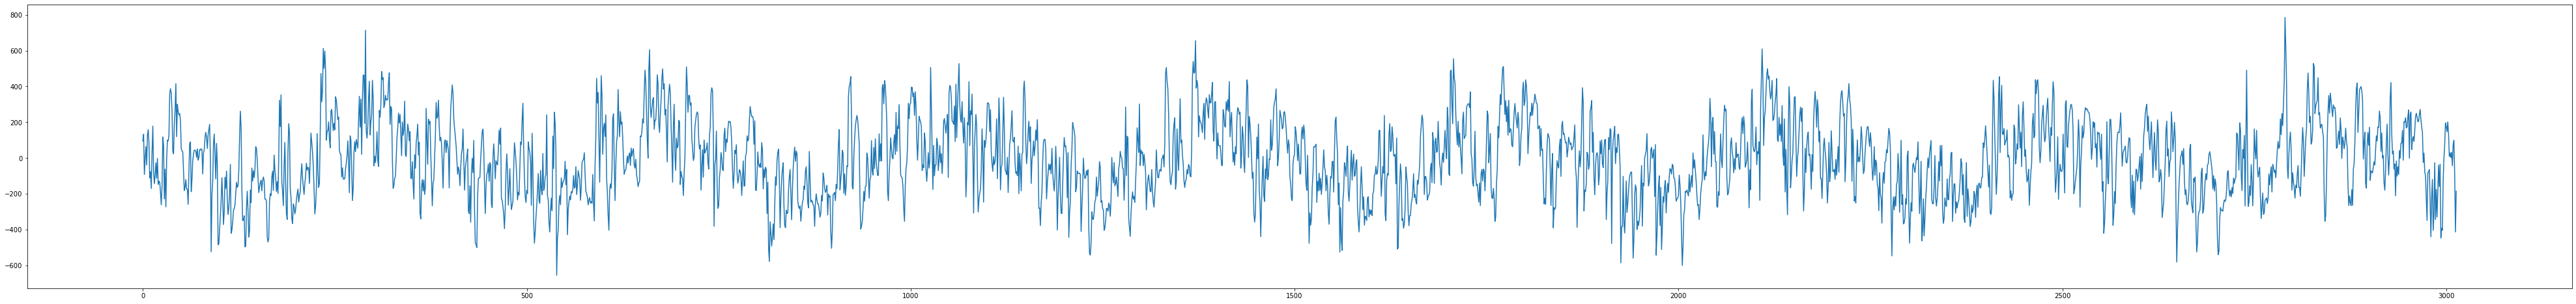

In [ ]:
cons = observatoire["TX"]

cons.dropna(inplace=True)

detr = scipy.signal.detrend(cons)

len = cons.index.size
avg = cons.rolling(30 * 1).mean()
std = cons.rolling(30 * 1).std()
clt = math.sqrt(len) * (cons - avg) / std

clt = clt[41000:]

xx = clt - detr[41000:]


plt.figure(figsize=(70, 8))
plt.plot(range(0, xx.shape[0]), xx)
